In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

--2019-06-11 08:18:19--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.73.150
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.73.150|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz.1’

train-images-idx3-u 100%[===================>]  25.20M  15.9MB/s    in 1.6s    

2019-06-11 08:18:21 (15.9 MB/s) - ‘train-images-idx3-ubyte.gz.1’ saved [26421880/26421880]

--2019-06-11 08:18:22--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.73.150
Connecting to fashion-mnist.s3-website.eu-central-1.

In [3]:
!mkdir MNIST_Fashion
!cp *.gz MNIST_Fashion/

mkdir: cannot create directory ‘MNIST_Fashion’: File exists


In [4]:
from tensorflow.examples.tutorials.mnist import input_data
# For GAN
mnist= input_data.read_data_sets("MNIST_Fashion/")


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_Fashion/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_Fashion/train-labels-idx1-ubyte.gz
Extracting MNIST_Fashion/t10k-images-idx3-ubyte.gz
Extracting MNIST_Fashion/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [5]:
print(mnist.train.images.shape)
print(mnist.test.images.shape)
print(mnist.train.labels.shape)
print(mnist.test.labels.shape)

(55000, 784)
(10000, 784)
(55000,)
(10000,)


[0.         0.         0.         0.         0.         0.
 0.00784314 0.         0.         0.         0.17254902 0.67058825
 0.22352943 0.15294118 0.15294118 0.20392159 0.6313726  0.12156864
 0.         0.         0.         0.02745098 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00784314 0.         0.10196079
 0.39607847 0.5294118  0.4666667  0.73333335 0.8352942  0.67058825
 0.6313726  0.854902   0.7411765  0.5294118  0.5882353  0.29411766
 0.02745098 0.         0.01960784 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.01960784 0.         0.         0.6117647  0.6313726  0.45882356
 0.4666667  0.39607847 0.5882353  0.5882353  0.6901961  0.50980395
 0.35686275 0.4666667  0.5176471  0.5803922  0.6313726  0.00784314
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01960784 0.
 0.19215688 0.6627451  0.38431376 0.38431376 0.4274

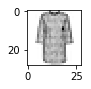

In [6]:
plt.figure(figsize=(1,1))
sample_image = mnist.train.next_batch(1)[0]
print(sample_image[0])

sample_image = sample_image.reshape([28,28])
plt.imshow(sample_image, cmap='Greys')

In [0]:
#Training Parameters 

learning_rate=0.0002
batch_size=128
epochs=100000

#Network Parameters

image_dim=784       # Image size is 28x28
gen_hidd_dim=256
disc_hidd_dim=256
z_noise_dim=100     # Input noise datapoint

def xavier_init(shape):
  return tf.random_normal(shape = shape, stddev = 1./tf.sqrt(shape[0]/2.0))

In [8]:
# Define weights and bias dictionaries

weights= {"disc_H" : tf.Variable(xavier_init([image_dim, disc_hidd_dim])),
          "disc_final" : tf.Variable(xavier_init([disc_hidd_dim, 1])),
          "gen_H" : tf.Variable(xavier_init([z_noise_dim, gen_hidd_dim])),
          "gen_final" : tf.Variable(xavier_init([gen_hidd_dim, image_dim]))
         }

bias= {"disc_H" : tf.Variable(xavier_init([disc_hidd_dim])),
       "disc_final" : tf.Variable(xavier_init([1])),
       "gen_H" : tf.Variable(xavier_init([gen_hidd_dim])),
       "gen_final" : tf.Variable(xavier_init([image_dim]))
      }





Instructions for updating:
Colocations handled automatically by placer.


In [0]:
#Creating the computational graph
#Define Discriminator function

def Discriminator(x):
  hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, weights["disc_H"]), bias["disc_H"]))
  final_layer = tf.add(tf.matmul(hidden_layer, weights["disc_final"]), bias["disc_final"])
  disc_output = tf.nn.sigmoid(final_layer)
  return final_layer, disc_output



# Define generator network 
def Generator(x):
  hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, weights["gen_H"]), bias["gen_H"]))
  final_layer = tf.add(tf.matmul(hidden_layer, weights["gen_final"]), bias["gen_final"])
  gen_output = tf.nn.sigmoid(final_layer)
  return gen_output


# Define the placeholders for External Input
x_input= tf.placeholder(tf.float32, shape = [None, image_dim], name="real_input")
z_input= tf.placeholder(tf.float32, shape = [None, z_noise_dim], name="input_noise")



# Building the Generator Network
with tf.name_scope("Generator") as scope:
  output_Gen = Generator(z_input)
 
 

# Buidling the Discriminator Network 
with tf.name_scope("Discriminator") as scope:
  real_output1_Disc, real_output_Disc = Discriminator(x_input) # Implements D(x)
  fake_output1_Disc, fake_output_Disc = Discriminator(output_Gen) # Implements D(G(x))
  


In [0]:
#First kind of loss
#with tf.name_scope("Discriminator_Loss") as scope:
 # Discriminator_Loss = -tf.reduce_mean(tf.log(real_output_Disc+0.0001) + tf.log(1.- fake_output_Disc+0.0001))
  
#with tf.name_scope("Generator_Loss") as scope:
 # Generator_Loss = -tf.reduce_mean(tf.log(fake_output_Disc+0.0001)) # due to max log(D(G(x)))
  
# Tensorboard Summary
#Disc_loss_total = tf.summary.scalar("Disc_Total_loss", Discriminator_Loss)
#Gen_loss_total = tf.summary.scalar("Gen_Loss", Generator_Loss)

In [0]:
# Second kind of loss
Disc_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = real_output1_Disc, labels= tf.ones_like(real_output1_Disc)))
Disc_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = fake_output1_Disc, labels= tf.zeros_like(fake_output1_Disc)))
Discriminator_Loss = Disc_real_loss + Disc_fake_loss

Generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = fake_output1_Disc, labels= tf.ones_like(fake_output1_Disc)))

#Tensorboard Summary
Disc_loss_real_summary = tf.summary.scalar("Disc_loss_real", Disc_real_loss)
Disc_loss_fake_summary = tf.summary.scalar("Disc_loss_fake", Disc_fake_loss)
Disc_loss_summary = tf.summary.scalar("Disc_Total_Loss", Discriminator_Loss)

Disc_loss_total = tf.summary.merge([Disc_loss_real_summary, Disc_loss_fake_summary])
Gen_loss_total = tf.summary.scalar("Gen_Loss", Generator_loss)


In [0]:
# Define the variables

Generator_var = [weights["gen_H"], weights["gen_final"], bias["gen_H"], bias["gen_final"]]
Discriminator_var = [weights["disc_H"], weights["disc_final"], bias["disc_H"], bias["disc_final"]]

In [0]:
#Define the optimizer 

with tf.name_scope("Optimizer_Discriminator") as scope:
  Discriminator_optimize = tf.train.AdamOptimizer(learning_rate= learning_rate).minimize(Discriminator_Loss, var_list= Discriminator_var)
  
with tf.name_scope("Optimizer_Generator") as scope:
  Generator_optimize = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(Generator_loss, var_list= Generator_var)

In [16]:
# Initialize the variables
init = tf.global_variables_initializer()

sess=tf.Session()
sess.run(init)
writer = tf.summary.FileWriter("./log", sess.graph)

for epoch in range(epochs):
  X_batch, _ = mnist.train.next_batch(batch_size)
  
  # Generate noise to feed the discriminator
  z_noise = np.random.uniform(-1.,1., size = [batch_size, z_noise_dim])
  _, Disc_loss_epoch= sess.run([Discriminator_optimize, Discriminator_Loss], feed_dict = {x_input:X_batch, z_input:z_noise})
  _, Gen_loss_epoch = sess.run([Generator_optimize, Generator_loss], feed_dict = {z_input:z_noise}) 
  
  
  # Running the Discriminator summary
  summary_Disc_Loss = sess.run(Disc_loss_total, feed_dict={x_input:X_batch, z_input:z_noise})
  
  
  # Adding the Discriminator summary
  writer.add_summary(summary_Disc_Loss, epoch)
  
  # Running the Generator summary
  summary_Gen_Loss = sess.run(Gen_loss_total, feed_dict={z_input:z_noise})
  
  
  #Adding the Generator summary
  writer.add_summary(summary_Gen_Loss, epoch)
  
  if epoch % 2000 ==0:
    print("Steps: {0} : Generator Loss: {1}, Discriminator Loss: {2}".format(epoch, Gen_loss_epoch, Disc_loss_epoch))
  

Steps: 0 : Generator Loss: 0.3209115266799927, Discriminator Loss: 1.968876838684082
Steps: 2000 : Generator Loss: 4.933677673339844, Discriminator Loss: 0.036030448973178864
Steps: 4000 : Generator Loss: 2.711879014968872, Discriminator Loss: 0.35391300916671753
Steps: 6000 : Generator Loss: 2.8958358764648438, Discriminator Loss: 0.24278205633163452
Steps: 8000 : Generator Loss: 2.8638534545898438, Discriminator Loss: 0.4283747673034668
Steps: 10000 : Generator Loss: 2.6314687728881836, Discriminator Loss: 0.4844774901866913
Steps: 12000 : Generator Loss: 1.8808499574661255, Discriminator Loss: 0.5757508873939514
Steps: 14000 : Generator Loss: 2.298978090286255, Discriminator Loss: 0.4740949273109436
Steps: 16000 : Generator Loss: 2.483309030532837, Discriminator Loss: 0.5018972158432007
Steps: 18000 : Generator Loss: 2.6992921829223633, Discriminator Loss: 0.4968612790107727
Steps: 20000 : Generator Loss: 2.389803647994995, Discriminator Loss: 0.5776816010475159
Steps: 22000 : Gener

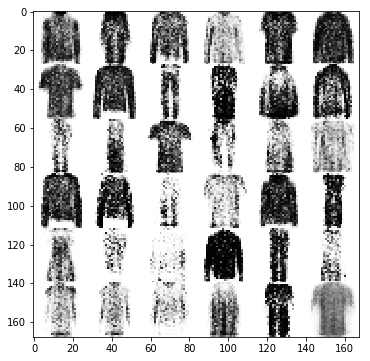

In [19]:
#Testing
# Generate images from noise, using the generator network 

n=6
canvas = np.empty((28*n, 28*n))
for i in range(n):
  #Noise input
  z_noise= np.random.uniform(-1.,1.,size= [batch_size, z_noise_dim])
   #Generate image from noise
  g = sess.run(output_Gen, feed_dict={z_input: z_noise})
   #Reverse colors for better display
  g = -1 *(g-1)
  for j in range(n):
    # Draw the generated digits
    canvas[i * 28:(i+1) *28, j * 28:(j+1) *28] = g[j].reshape([28,28])
    
plt.figure(figsize=(n,n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()